# TEST CODE

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

"""
    %matplotlib inline 이란, Jupyter Notebook에서 사용하는 매직 명령어로, 
    그래프나 플롯을 코드 셀 아래에 직접 표시하도록 한다. 
    그래프가 별도의 팝업창을 띄우지 않고 코드 셀 아래에 바로 출력셀로 나타난다.
"""
%matplotlib inline 

In [122]:
# h5 구조를 확인하는 방법
"""
[구조]
    Dataset (여러개)
        - name
        - shape
        - data type(dtype)
    Group
        - group name
        - sub name (여러개)
            - name
            - shape
            - data type(dtype)

    *요약* Dataset을 여러개 모은것을 Group으로 하고, Dataset은 단일구성이다.
"""
def checkH5design(file_path):
    print(f"\n## analysis file of [{file_path}] ##")
    with h5py.File(file_path, 'r') as h5_file:
        for name in h5_file:
            dataset = h5_file[name]
            if isinstance(dataset, h5py.Dataset):
                print(f"Dataset: {name}")
                print(" - Shape:", dataset.shape)
                print(" - Data type:", dataset.dtype)
            elif isinstance(dataset, h5py.Group):
                print(f"Group: {name}")
                print(" - Sub-items:")
                for sub_name in dataset:
                    sub_dataset = dataset[sub_name]
                    print(f"   - {sub_name} (Shape: {sub_dataset.shape}, Type: {sub_dataset.dtype})")

trainDataSet = 'datasets/train_catvnoncat.h5'
testDataSet = 'datasets/test_catvnoncat.h5'
checkH5design(trainDataSet)
checkH5design(testDataSet)


## analysis file of [datasets/train_catvnoncat.h5] ##
Dataset: list_classes
 - Shape: (2,)
 - Data type: |S7
Dataset: train_set_x
 - Shape: (209, 64, 64, 3)
 - Data type: uint8
Dataset: train_set_y
 - Shape: (209,)
 - Data type: int64

## analysis file of [datasets/test_catvnoncat.h5] ##
Dataset: list_classes
 - Shape: (2,)
 - Data type: |S7
Dataset: test_set_x
 - Shape: (50, 64, 64, 3)
 - Data type: uint8
Dataset: test_set_y
 - Shape: (50,)
 - Data type: int64


In [123]:
def load_dataset():
    """
    # h5 확장자 파일이란?
      - h5 파일은 계층구조로 포함된 파일 시스템과 비슷한 형태를 가지고 있다.
        바이너리 포멧으로 데이터를 저장하기 때문에 이미지나 숫자 데이터 처럼 크고 복잡한 데이터 구조를 담을 수 있다.
    """
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels
    #print(train_set_y_orig.shape)

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    """
    # h5 파일에 list_classes 데이터 셋을 넣은 이유?
      - *[코드 가독성 향상]* *클래스 레이블을 더 명확하고 직관적*으로 이해할 수 있도록 하기 위함이다.
        예를 들어 train_set_y 0과 1은 인간이 이해하기 어려운 내용이므로, list_classes 라는 클래스 레이블을만들어서 
        직관적으로 이해할 수 있도록 한다.
      - *[데이터셋 재사용성]* 데이터셋에 새로운 클래스가 추가되거나, 클래스 레이블이 여러 개로 확장될 경우 0,1 과 같은
        숫자형 레이블 대신, 문자열 기반의 클래스명을 직접 사용하여 코드의 수정 없이 의미를 명확하게 전달할 수 있다.
    """
    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    """ 
    # reshape 하는 이유 ? 
      - 코드를 편리하게 사용하기 위함이다. 
      - 예를 들어 (209, ) shape의 array의 경우 1차원 배열이지만, (1, 209) 의 경우 2차원 배열이라 재사용성이나 가독성에 뛰어나다.
    """
    
    #print("<reshape>")
    #print(train_set_y_orig.shape)
    #print(train_set_y_orig)
    #print(train_set_y_orig[0])
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [124]:
# Loading the data (cat/ non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()
"""
    <train data set>
    train_set_x_orig = example datas
    train_set_y = example labeling data

    <test data set>
    test_set_x_orig = test image data
    test_set_y = test labeling data
"""

"""
    첫 번째 차원 (1): 이미지 개수를 나타내며, 이 경우 1개의 이미지만 포함하고 있습니다.
    두 번째 차원 (64): 이미지의 **세로(높이)**에 해당하며, 픽셀 위치를 나타냅니다.
    세 번째 차원 (64): 이미지의 **가로(너비)**에 해당하며, 역시 픽셀 위치를 나타냅니다.
    네 번째 차원 (3): 각 픽셀의 색상 정보를 나타내는 RGB 채널 값입니다.
"""
# do print
print(train_set_x_orig.shape) #(209, 64, 64, 3) # 209 개의 64 by 64 로 정형화된 이미지가 저장되어 있으며, 3은 RGB를 나타낸다.
print(train_set_y.shape)
print(test_set_x_orig.shape)
print(test_set_y.shape)
print(classes.shape)

(209, 64, 64, 3)
(1, 209)
(50, 64, 64, 3)
(1, 50)
(2,)


In [125]:
# 랜덤 숫자 배열 하나를 만들어보기
example_data = np.random.rand(1,64,64,3)
"""
    - (1,64,64,3) 은 (image 순서, Y, X, RGB 이다.) ## X = 가로, Y = 세로
    - 예를 들어 print(example_data[0, 0, 10]) 의 경우 X = 10, Y = 0 을 나타낸다

"""
print(example_data.shape) # (1,64,64,3)
print(example_data[0,0,10]) # X = 10, Y = 0 위치의 값을 출력하는 코드 이다.

(1, 64, 64, 3)
[0.58154145 0.29796996 0.49762823]


[206 116 107]
[144 206 235]


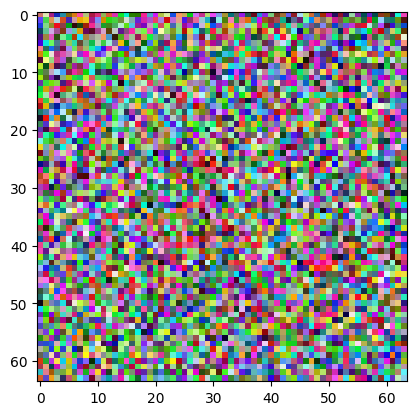

In [126]:
# 랜덤 이미지 파일을 만들어보기
# unsigned 8-bit integer, '유니트팔' 으로 선언하는 이유는 RGB 값이 255개의 값을 가지기 때문이다.

#random image
# 0 ~ 255 까지의 숫자를 랜덤으로 (64, 64, 3) shape의 배열에 넣어라. 
# 64 = X, Y 위치정보 이고 3은 RGB 값이다.
rd_picture_example_data = np.random.randint(0, 255, (64,64,3), dtype=np.uint8 ) #random color image create

#black image
bl_image = np.zeros((64, 64, 3), dtype=np.uint8) #8바이트의 정수까지가 RGB의 한계이기 때문에 uint8으로 한다. 

#white image
wh_image = np.full((64, 64, 3), 255, dtype = np.uint8) # white image create

"""
    - 3차원 배열이기 때문에 이미지 index를 넣을 필요 없이 Y, X 좌표를 가지고 RGB를 출력할 수 있다. 
    - 왼쪽 상단(0,0) 부터 우측 하단까지 (63,63) 까지의 범위로 생성되어 있다. 
"""
print(rd_picture_example_data[0,0])  # 좌측 최상단
print(rd_picture_example_data[63,63]) # 우측 최하단
plt.imshow(rd_picture_example_data)

#plt.imshow(bl_image)
#plt.imshow(wh_image)

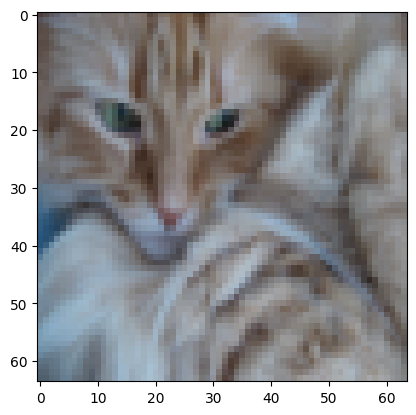

In [127]:
def showImage(index) : 
    #plt.imshow(train_set_x_orig[index])
    #y를 10 에서 50까지, x를 10 에서 50 까지, rgb는 전부 넣어서 출력
    #plt.imshow(train_set_x_orig[index][10:50, 10:50, :]) 
    
    # 상하 좌우 반전
    #plt.imshow(train_set_x_orig[index][50:10:-1, 50:10:-1, :])
    # 상하 반전
    #plt.imshow(train_set_x_orig[index][50:10:-1, 10:50:1, :])
    # 좌우 반전
    #plt.imshow(train_set_x_orig[index][10:50, 50:10:-1, :])
 
    # step을 2개씩 건너뛰어서 출력
    # plt.imshow(train_set_x_orig[index][::2, ::2, :])
    # step을 3개씩 건너 뛰어서 출력
    # plt.imshow(train_set_x_orig[index][::3 ,::3, :])

    #명도 조정 
    plt.imshow(train_set_x_orig[index] - 8)

showImage(2)

In [128]:
# sigmoid 를 만들자.
def sigmoid(z):
    """
        Compute the sigmoid of z
        Arguments : 
        z -- A scalar or numpy array of any size.

        Return:
        s -- sigmoid(z)  
    """


    """
        1. np.exp란?
            > 자연 로그의 밑수인 e를 사용한 지수 함수 이다.
            > e^(-z) 중 z가 음수 혹은 양수 인 경우에 따라 값의 크기가 다르다.
            > e 는 자연로그의 밑(약 2.718)

        2. 1을 더하는 이유?
            > 무조껀 1보다 큰 값을 만들기 위해서 이다. 

        3. 1에다 결과값을 나누는 이유?
            > 0~1 사이에 값을 나타내기 위해서 이다.
            > z가 음수일경우 0에 가깝고, 양수일 경우 1에 가깝다.
            > z = 0 일때 s = 1이다.
        
        4. z란?
            > z는 선형 결합 값으로, 머신러닝 모델에서 주로 '**입력(features)**과 **가중치(weights)**의 결합'을 통해 계산된 값입니다. 
            로지스틱 회귀나 인공 신경망에서 z는 예측을 하기 위한 중간 값으로 사용됩니다.

            설명 예시:
                로지스틱 회귀 모델:
                    "z는 입력 데이터 X와 모델의 가중치 w의 선형 결합"입니다.
                    이 값 z는 **활성화 함수(Sigmoid 함수)**에 입력으로 들어가서 확률로 변환됩니다.
                인공 신경망:
                    z는 각 층에서 입력 X와 가중치 w의 선형 결합 값입니다.
                    이 값은 활성화 함수에 의해 비선형 값으로 변환됩니다.
    """
    s = 1 / (1 + np.exp(-z))

    return s

print(np.array([0,2])) # 배열 {0,2} 출력
print(sigmoid(np.array([0,2]))) # 배열 {0,2}에 broad cast로 sigmoid 적용
print(sigmoid(np.array([-2,2]))) 
test = sigmoid(-2) + sigmoid(2)
print(test)

[0 2]
[0.5        0.88079708]
[0.11920292 0.88079708]
0.9999999999999999


In [129]:
def initialize_with_zeros(dim) : 
    """
        This function creates a vector of zeros of shape (dim, 1)

        Argument : 
        dim -- size of the w vector we want 
                (or number of parameters in this case)
        
        Returns : 
        w -- initialized vector of shape (dim , 1)
        b -- initialized scalar (corresponds to the bias)
         ## scalar : 방향성이 없는 하나의 숫자
         ## bias : 모델이 예측할때 상수로 추가되는 항 (바이아스)
    """

    # :: (dim, 1) 크기로 제로 백터 생성 :: #
    w = np.zeros((dim, 1))

    # :: b 를 정수가 아닌 실수로 선언 (scalar - bias) :: #
    b = 0. 

    assert(w.shape == (dim, 1))
    """ 
        isinstance() == 어떤 객체가 특정한 class나 type인지 확인하는 함수
    """
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b

In [130]:
dim = 2
w, b = initialize_with_zeros(dim)
print(w)
print(w.shape)
print(b)

[[0.]
 [0.]]
(2, 1)
0.0


In [131]:
# Forward and Backward propagation
# (순방향 및 역방향 전파)
def propagate(w, b, X, Y):
    """
        Implement the cose function and its gradient for the propagation explained above

        Arguments : 
            w -- weights, a numpy array of size (num_px * num_px * 3, 1)
            b -- bias, a scalar
            X -- data of size (num_px * num_px * 3, number of examples)
            Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

        Return : 
            cost -- negative log-likelihood cost for logistic regression
            dw -- gradient of the loss with respect to w, thus same shape as w
            db -- gradient of the loss with respect to b, thus same shape as b
                # thus = 따라서
    """


    # !! start region - *forward propagation*    
    """
        forward propagation -- from X to COST

        np.dot(w.T, X) + b 란?
            > 각 행렬의 합과 bias를 더한 결과 값이다. $npdottest() 함수 참조.
            > w.T -- weights transpose
            > X -- image 행렬
            > b -- bias
            > dot -- 성형 회귀 계산
            > np.dot(w.T, X) -- 입력 데이터 X와 가중치 w의 선형 결합을 수행
             > > np.dot 내부의 선형 결합은 각각 곱해주고 전체의 항을 더해준다.
            > +b -- 바이아스 더해줌
 
        A 란?
            > 예측된 결과 값을 sigmoid를 통해 0~1사이의 실수 값을 가진다.

        w.T 결과 값 비교
            > w = [[1.] [2.]] ,	 w.T = [[1. 2.]]
            > w.shape = (2, 1) # 두개의 배열에 하나씩 값이 있음
            > w.T.shape = (1, 2) # 한개의 배열에 두개 값이 있음

        
        np.dot(w.T, X) 풀이
            > X shape : (2, 3)
            > w.T shape : (1, 2)
            > (step1) w.T[0][0] * X[0][0] + w.T[0][1] * X[1],[0]
            > (step2) w.T[0][0] * X[0][1] + w.T[0][1] * X[1],[1]
            > (step3) w.T[0][0] * X[0][2] + w.T[0][1] * X[1],[2]
        
        예시)) 
            w.T = [[1. 2.]] 
            X = [[ 1.   2.  -1. ]  [ 3.   4.  -3.2]]
             > 첫 번째 원소: 1*1 + 2*3 = 1+6=7
             > 두 번째 원소: 1*2 + 2*4 = 2+8=10
             > 세 번째 원소: 1*−1 + 2*−3.2 = −1+(−6.4)=−7.4
    """
    print(f"w.T shape : {w.T.shape} , X shape : {X.shape}")
    print(f"w.T = {w.T} , X = {X}")
    print(f"w.T and W dot result = {np.dot(w.T, X)}")
    Z = np.dot(w.T, X) + b
    A = sigmoid(Z)

    """
        cost란?
        binary cross-entropy loss (이중 교차 엔트로피 손실) 계산
            > np.mean -- 평균 값 계산
            > Y -- 정답(구분) 값
            > A -- 예측확률 값 
        cost : 0에 가까울 수록 좋다. 이유? 실제 labeling 값과 예측값의 오차 범위이기 때문이다.

        Y = 1일 때: 
            > 예측 값 A가 1에 가까울수록 손실이 낮다.
            > 예측 값 A가 0에 가까울수록 손실이 크다.

        Y = 0일 때: 
            > 예측 값 A가 0에 가까울수록 손실이 낮다.
            > 예측 값 A가 1에 가까울수록 손실이 크다.
        
        m 이란?
            > X의 datasize 
            > 예측값의 합의 평균을 내기 위해서 변수를 선언한다.
        
        np.mean을 사용하지 않고 평균 cost를 내는 코드
            > cost = -1/m * np.sum(Y * np.log(A) + (1-Y) * np.log(1-A))

        1과 0에 대한 평균을 구하는 이유?
            > class가 0,1 로 구분되는데, 0일때와 1일때 모두 얼마나 잘 예측했는지 알기 위해서 0과 1의 예상결과의 합을 평균낸다.
            > Y * np.log(A)의 경우, 실제 값 Y가 1일때만 영향을 미친다. 
            > (1-Y) * np.log(1-A)의 경우, 실제 값 Y가 0일때만 영향을 미친다.
    """
    m = X.shape[1]
    cost = -np.mean(Y * np.log(A) + (1-Y) * np.log(1-A))
    # !! end region - *forward propagation*

    # !! start region - *backward propagation*
    """
        * Gradient descent(경사 하강법) 을 적용할때 w, b를 구한다. 
        * weight 와 bias를 업데이트를 하는데 필요한 편미분값(기울기)를 구한다.
        * db, dw에서 d란? 편미분 혹은 기울기(grediant) 라고 한다.
            > d는 "∂"(부분 미분 기호)로 읽힐 수 있다.

        # dw를 구하는 방법?
            > w -- 가중치 (weight)
            > b -- 바이어스 (bias)
            > m -- 샘플의 개수 (X.shape[1])
            > dw -- 가중치에 대한 기울기 
            > (A - Y) -- 예측확률과 labeling 값을 뺀다. (Y 는 0 or 1, A = sigmode를 진행한 예측 값.)
            > (A - Y).T -- 행과 열을 서로 바꾼다. (.T를 이용하여 바꿈.)
            > np.dot(X, (A - Y).T) -- 샘플과 오차 배열의 곱셈의 합이다.
            > (1/m) * np.dot(X, (A-Y).T) -- 가중치를 구하기 위해 샘플의 개수에 나눠준다.

        # db - bias 를 구한다.
            > (1/m) * np.sum(A-Y) -- 오차의 합의 평균을 구한다.

        # 요약 
            > dw -- 가중치에 대한 기울기
            > db -- bias에 대한 기울기 (scalar)
    """
    #print(f"[propagate][shape]\n\t X = {X.shape} ,\n\t w = {w.shape} ,\n\t w.T = {w.T.shape} ,\n\t A = {A.shape} ,\n\t Y = {Y.shape} ,\n\t (A-Y).T = {((A-Y).T).shape}")
    #print(f"[propagate][value]\n\t X = {X},\n\t w = {w} ,\n\t w.T = {w.T}\n\t A = {A}\n\t Y = {Y}\n\t (A-Y).T = {(A-Y).T}")
    #print(f"(A-Y) = {(A-Y)}") ## (1,3)
    #print(f"(A-Y).T = {(A-Y).T}") ## (3, 1)
    dw = (1/m) * np.dot(X, (A - Y).T)
    db = (1/m) * np.sum(A-Y)
    # !! end region - *backward propagation*

    ##debugging
    assert(dw.shape == w.shape)
    assert(db.dtype == float)

    """
        # np.squeeze 란? 
            > 차원의 축이 1인것을 제거하는 함수이다.
    """
    cost = np.squeeze(cost) ## squeezetest 참조
    assert(cost.shape == ())

    grads = {}
    grads["dw"] = dw
    grads["db"] = db

    return grads, cost


# propagate TEST
def propagatetest () : 
    #print("do propagate test")
    w = np.array([[1.],[2.]]) ## weigh 
    b = 2. ## bias
    X = np.array([[1.,2.,-1.],[3.,4.,-3.2]]) ## sample
    Y = np.array([[1,0,1]]) ## labeling
    #print(f"\tshapes | w= {w.shape} , X = {X.shape} , Y = {Y.shape}")
    ## w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])

    grads, cost = propagate(w, b, X, Y)
    #print ("\tdw = " + str(grads["dw"]))
    #print ("\tdb = " + str(grads["db"]))
    #print ("\tcost = " + str(cost))

propagatetest()

w.T shape : (1, 2) , X shape : (2, 3)
w.T = [[1. 2.]] , X = [[ 1.   2.  -1. ]
 [ 3.   4.  -3.2]]
w.T and W dot result = [[ 7.  10.  -7.4]]


In [132]:
# what is np.squeeze() ?
def squeezetest() : 
    # example 01
    # (1, 3, 1) 크기의 배열
    a = np.array([[[1], [2], [3]]])
    print(a.shape)  # 출력: (1, 3, 1)

    # np.squeeze() 적용
    a_squeezed = np.squeeze(a)
    print(a_squeezed.shape)  # 출력: (3,)

    #  example 02
    ## squeeze가 안되는 경우.
    c = np.array([[1, 2, 3], [4, 5, 6]])  # (2, 3) 배열
    print(c.shape)  # 출력: (2, 3)

    # np.squeeze()를 적용해도 제거되지 않음, 차원이 1인 축이 없기 때문에 제거 되지 않는다. 
    c_squeezed = np.squeeze(c)
    print(c_squeezed.shape)  # 출력: (2, 3)

In [133]:
## What is np.dot ? 
def npdottest() : 
    a = np.array([1, 2, 3])
    b = np.array([4, 5, 6])
    result = np.dot(a, b)
    print(result)  # 출력: 32 (1*4 + 2*5 + 3*6)

npdottest()

32


In [134]:
## binary cross entropy loss 구하는 EXAMPLE
def binary_cross_entropy_loss(Y, A):
    m = Y.shape[0]  # 데이터 샘플의 수
    print(m)
    print(Y)
    print(A)
    cost = -np.mean(Y * np.log(A) + (1 - Y) * np.log(1 - A))
    return cost

# 실제 값 (Y)와 예측 값 (A)
Y = np.array([1, 0, 1, 0])  # 실제 레이블
A = np.array([0.9, 0.1, 0.8, 0.3])  # 예측 확률

# 손실 계산
loss = binary_cross_entropy_loss(Y, A)
print("Binary Cross-Entropy Loss:", loss)


4
[1 0 1 0]
[0.9 0.1 0.8 0.3]
Binary Cross-Entropy Loss: 0.19763488164214868


w.T shape : (1, 2) , X shape : (2, 3)
w.T = [[1. 2.]] , X = [[ 1.   2.  -1. ]
 [ 3.   4.  -3.2]]
w.T and W dot result = [[ 7.  10.  -7.4]]
w.T shape : (1, 2) , X shape : (2, 3)
w.T = [[0.9910139  1.97844435]] , X = [[ 1.   2.  -1. ]
 [ 3.   4.  -3.2]]
w.T and W dot result = [[ 6.92634694  9.89580519 -7.32203581]]
w.T shape : (1, 2) , X shape : (2, 3)
w.T = [[0.98202891 1.95689227]] , X = [[ 1.   2.  -1. ]
 [ 3.   4.  -3.2]]
w.T and W dot result = [[ 6.85270573  9.79162691 -7.24408418]]
w.T shape : (1, 2) , X shape : (2, 3)
w.T = [[0.97304514 1.93534406]] , X = [[ 1.   2.  -1. ]
 [ 3.   4.  -3.2]]
w.T and W dot result = [[ 6.77907731  9.68746651 -7.16614612]]
w.T shape : (1, 2) , X shape : (2, 3)
w.T = [[0.96406267 1.91380001]] , X = [[ 1.   2.  -1. ]
 [ 3.   4.  -3.2]]
w.T and W dot result = [[ 6.70546271  9.5833254  -7.08822271]]
w.T shape : (1, 2) , X shape : (2, 3)
w.T = [[0.95508162 1.89226047]] , X = [[ 1.   2.  -1. ]
 [ 3.   4.  -3.2]]
w.T and W dot result = [[ 6.63186303  9.4792

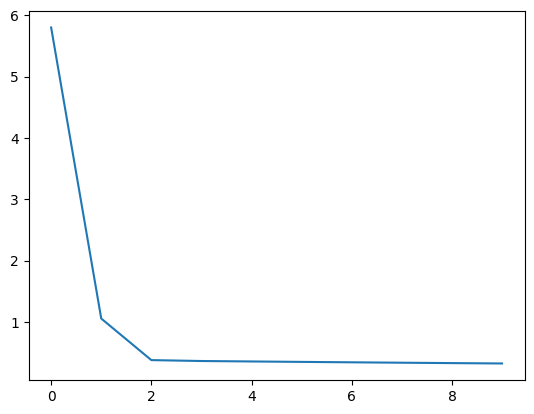

In [135]:
# GRADED FUNCTION : optimize

""" 
    # optimize 란?
        > logistic regression 에서 optimize는 모델의 파라미터 [w(가중치), b(bias)]를 학습하는 과정 이다.
    
    # GRADED FUNCTION 란?
        > 과제나 평가를 위해 구현해야 하는 함수 이다.

    # optimize의 주요 역할
        > *손실 함수 계산* : 예측 값과 실제 값 사이의 손실(오차)을 계산합니다.
        > *기울기 계산* : 손실 함수의 기울기(gradient)를 계산하여, 가중치 w와 바이어스 b가 손실을 얼마나 줄일 수 있을지 평가합니다.
        > *가중치와 바이어스 업데이트* : 기울기를 사용해 가중치와 바이어스를 조금씩 조정하여 손실을 줄이는 방향으로 이동시킵니다.
        > *최적화 반복* : 경사 하강법 등을 반복하여, 손실 값이 최소가 되는 지점을 찾습니다.
        
"""
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False) : 
    """
        This function optimizes w and b by running a gradient descent algorithm.
            *gradient descent algorithm : 경사 하강법
        
        Arguments : 
            w -- Weights, a numpy array of size (num_px * num_px * 3 , 1)
            b -- bias, a scalar
            X -- data of shape (num_px * num_px * 3, number of examples)
            Y -- true "label" vector , of shape (1, number of examples)
            num_iterations -- number of iterations of the optimization loop
            learning_rate -- learning rate of the gradient descent update rule
            print_cost -- True to print the loss every 10 steps

        Returns : 
            params -- dictionary containing the weights w and bias b
            grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
            costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

        Tips : 
            you basically need to write down two steps and iterate through them : 
                1) Calculate the cost and the gradient for the current parameters. Use propagate().
                2) Update the parameters using gradient descent rule for w and b.
    """
    costs = []
    for i in range(num_iterations) : 
        grads, cost = propagate(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]

        w -= learning_rate * dw
        b -= learning_rate * db

        #100 번에 한번씩 cost를 넣어서 cost의 추세를 확인하기 위함.
        if i % 100 == 0:
            costs.append(cost)

        if print_cost and i % 100 == 0 : 
            print ("Cost after iteration %i : %f" %(i, cost))
    
    params = {}
    grads = {}

    params["w"] = w
    params["b"] = b

    grads["dw"] = dw
    grads["db"] = db

    return params, grads, costs


def optimizetest () : 
    w = np.array([[1.],[2.]]) ## weigh 
    b = 2. ## bias
    X = np.array([[1.,2.,-1.],[3.,4.,-3.2]]) ## sample
    Y = np.array([[1,0,1]]) ## labeling
    params, grads, costs = optimize(w, b, X, Y, num_iterations= 1000, learning_rate = 0.009, print_cost = False)

    print ("w = " + str(params["w"]))
    print ("b = " + str(params["b"]))
    print ("dw = " + str(grads["dw"]))
    print ("db = " + str(grads["db"]))
    plt.plot(costs)

optimizetest()

In [143]:
# predict

def predict(w, b, X) : 
    '''
        Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

        Arguments : 
            w -- weights
            b -- bias
            X -- data of size

        Returns : 
            Y_predictions -- a numpy array (vector) containing all predictions (0/1) for the *examples in X*
    '''

    w = w.reshape(X.shape[0], 1) #
    z = np.dot(w.T, X) + b
    A = sigmoid(z)

    m = X.shape[1]

    # shape = (1, m) 
    Y_prediction = np.zeros((1, m))  
    print(Y_prediction)
    print(A)

    Y_prediction[A > 0.5] = 1
    print(Y_prediction.shape)
    print(Y_prediction)

    assert(Y_prediction.shape == (1,m))
    return Y_prediction

def predictiontest() : 
    w = np.array([[0.1124579], [0.23106775]])
    b = -0.3
    X = np.array([[1.,-1.1,-3.2], [1.2,2.,0.1]])
    print ("predictions = " + str(predict(w, b, X)))

predictiontest()


w = [[0.1124579 ]
 [0.23106775]], wshape = (2, 1)
X = [[ 1.  -1.1 -3.2]
 [ 1.2  2.   0.1]]
X shape[0] = 2
w = [[0.1124579 ]
 [0.23106775]], wshape = (2, 1)
[[0. 0. 0.]]
[[0.52241976 0.50960677 0.34597965]]
(1, 3)
[[1. 1. 0.]]
predictions = [[1. 1. 0.]]


In [ ]:
# MODEL

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False) : 
    """
    Builds the logistics regression model by calling the function you've implemented preciously

    Arguments : 
        X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
        Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
        X_test -- test set representes by a numpy array (vector) of shape (num_px * num_px * 3, m_test)
        Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
        num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
        learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
        print_cost -- Set to true to print the cost every 100 iterations

    Returns : 
        d -- dictionary containing information about the model.
    """

    ## w, b에 X_train 데이터 개수 개수의 배열을 생성해준다. 
    w, b = initialize_with_zeros(X_train.shape[0]) 

    ## Gradient descent
    params, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    w = params["w"]
    b = params["b"]

    Y_prediction_train = predict(w, b, X_train)
    Y_prediction_test = predict(w, b, X_test)
    
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d


def testoptimizedandpredict () : 
    d = model(train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, num_iterations = 20000, learning_rate = 0.002, print_cost = False)
    index = 40
    print(d["Y_prediction_test"][0, index])
    plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
    
#train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes